Import library

In [12]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

import keras._tf_keras.keras.backend as K
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Conv2D
from keras._tf_keras.keras.layers import Flatten, MaxPool2D, AvgPool2D
from keras._tf_keras.keras.layers import Concatenate, Dropout
from keras._tf_keras.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Load Data set

In [13]:

data_dir = r"C:\Users\rdali\Downloads\Tubes googlenet+strealit done\Train_data_tubes"  
data = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    seed=123, 
    image_size=(180,180), 
    batch_size=32
)

print("\nKelas yang terdeteksi:")
print(data.class_names)


class_names = data.class_names
img_size = 180
batch = 32


dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)


total_count = len(dataset)


train_count = int(total_count * 0.8)
val_count = int(total_count * 0.1)
test_count = total_count - train_count - val_count

print("\nPembagian Dataset:")
print("Total Images (Batches): ", total_count)
print("Train Images (Batches): ", train_count)
print("Validation Images (Batches): ", val_count)
print("Test Images (Batches): ", test_count)


train_ds = dataset.take(train_count)
remaining_ds = dataset.skip(train_count)
val_ds = remaining_ds.take(val_count)
test_ds = remaining_ds.skip(val_count)


Tuner = tf.data.AUTOTUNE
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)


Found 300 files belonging to 3 classes.

Kelas yang terdeteksi:
['Beras', 'Gandum', 'Sorgum']
Found 300 files belonging to 3 classes.

Pembagian Dataset:
Total Images (Batches):  10
Train Images (Batches):  8
Validation Images (Batches):  1
Test Images (Batches):  1


Augmentasi 

c:\Users\rdali\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


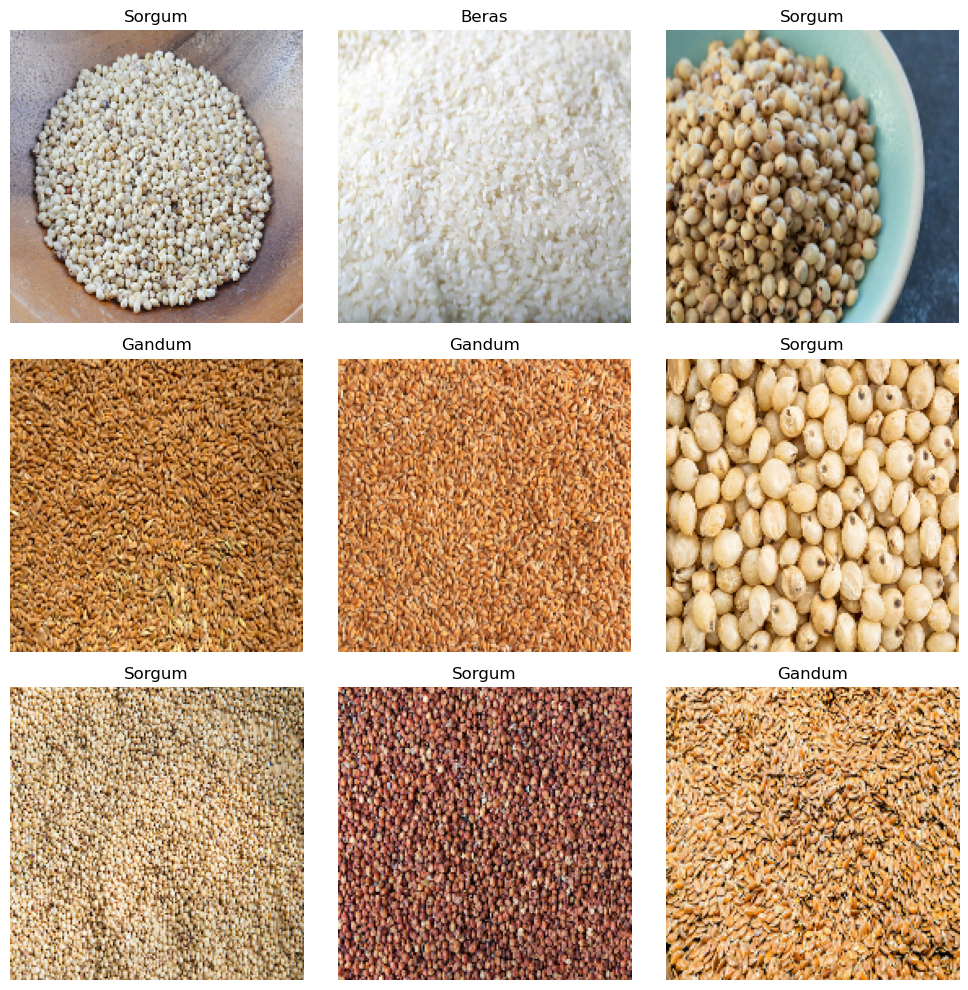

In [14]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size,img_size,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

i = 0
plt.figure(figsize=(10,10))


for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    

(32, 180, 180, 3)


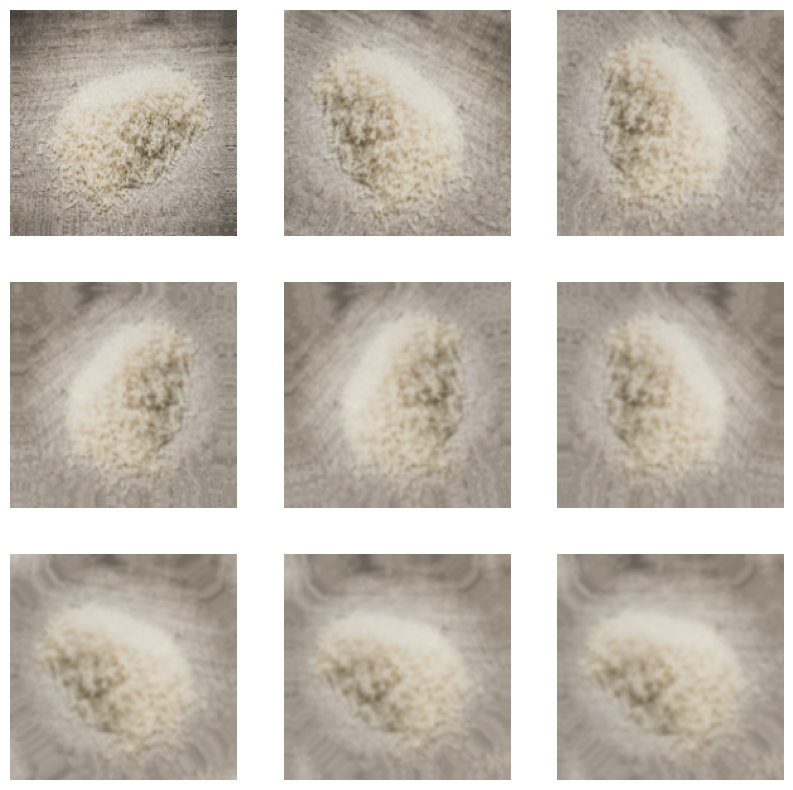

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)



data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1) 
])

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(69):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

googlenet   

In [17]:
def googlenet(input_shape, n_classes):
    def inception_block(x, f):
        
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        
        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)

        
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        
        t4 = MaxPool2D(3, strides=1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        
        output = Concatenate()([t1, t2, t3, t4])
        return output

    
    input = Input(input_shape)

    
    x = Conv2D(32, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = Conv2D(32, 1, activation='relu')(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)

    
    x = inception_block(x, [32, 48, 64, 8, 16, 16])  
    x = inception_block(x, [64, 64, 128, 16, 32, 32])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [96, 96, 192, 32, 48, 48])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [128, 128, 256, 32, 64, 64])
    x = inception_block(x, [160, 160, 320, 64, 96, 96])

    
    x = AvgPool2D(pool_size=3, strides=1, padding='valid')(x)
    x = Dropout(0.5)(x)

    
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)

    
    model = Model(input, output)
    return model

input_shape = (180, 180, 3)
n_classes = len(class_names)


K.clear_session()


model = googlenet(input_shape, n_classes)

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


print("\nArsitektur Model:")
model.summary()


Arsitektur Model:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      1,056 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,496 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 22, 22,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │      3,120 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22, 8) │        520 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 22, 22,    │     27,712 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │      3,216 │ conv2d_6[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │      1,040 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │      8,256 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 22, 22,    │      2,064 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,998,075 (7.62 MB)

 Trainable params: 1,998,075 (7.62 MB)

 Non-trainable params: 0 (0.00 B)

training

In [18]:

print("\nMemulai proses training...")
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               mode='max')
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)


Memulai proses training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - accuracy: 0.3568 - loss: 9.6081 - val_accuracy: 0.5455 - val_loss: 0.7287
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.5715 - loss: 0.7971 - val_accuracy: 0.5909 - val_loss: 0.5541
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.7162 - loss: 0.5423 - val_accuracy: 0.7955 - val_loss: 0.4865
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.7925 - loss: 0.4488 - val_accuracy: 0.8636 - val_loss: 0.3398
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.8029 - loss: 0.3740 - val_accuracy: 0.8864 - val_loss: 0.2936
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.7973 - loss: 0.4248 - val_accuracy: 0.8182 - val_loss: 0.4143
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.8226 - loss: 0.3611 - val_accuracy: 0.8864 - val_loss: 0.3416
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.8709 - loss: 0.3149 - val

graph accuracy

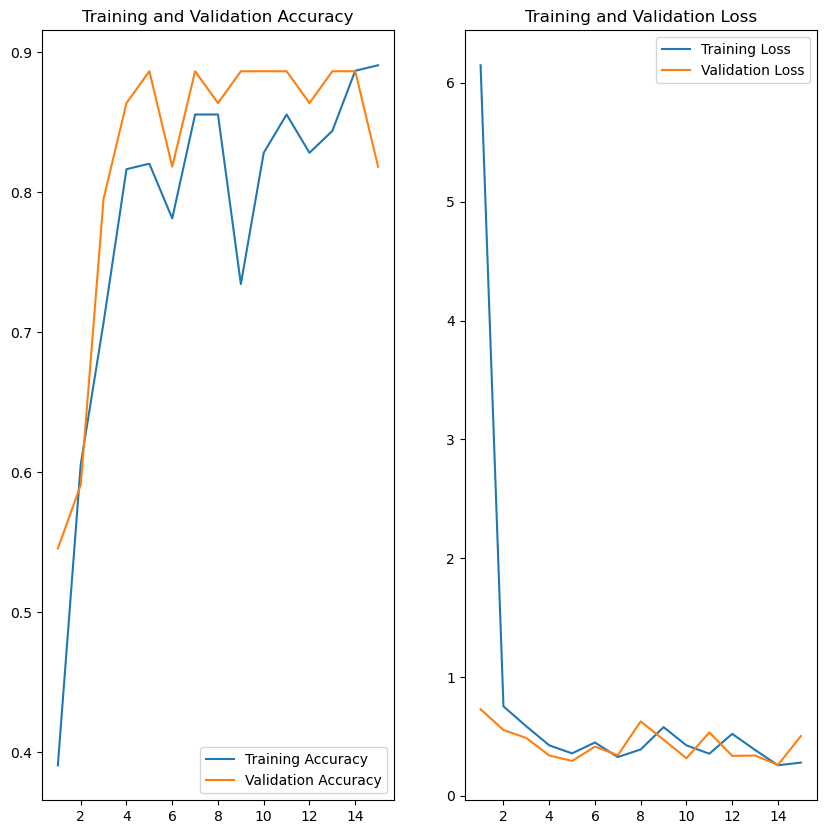

In [19]:
ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save('googlenet.h5')

test model

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'C:\Users\rdali\Downloads\Tubes googlenet+strealit done\googlenet.h5')  
class_names = ['Beras', 'Gandum', 'Sorgum']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  

        
        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        
        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        
        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"



result = classify_images(r'C:\Users\rdali\Downloads\Tubes googlenet+strealit done\Test_data_tubes\Sorgum\Sorgum 6.jpg', save_path = 'sorgum.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi: Sorgum
Confidence: 57.61%
Prediksi: Sorgum dengan confidence 57.61%. Gambar asli disimpan di sorgum.jpg.


Confussion Matrix

Found 30 files belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


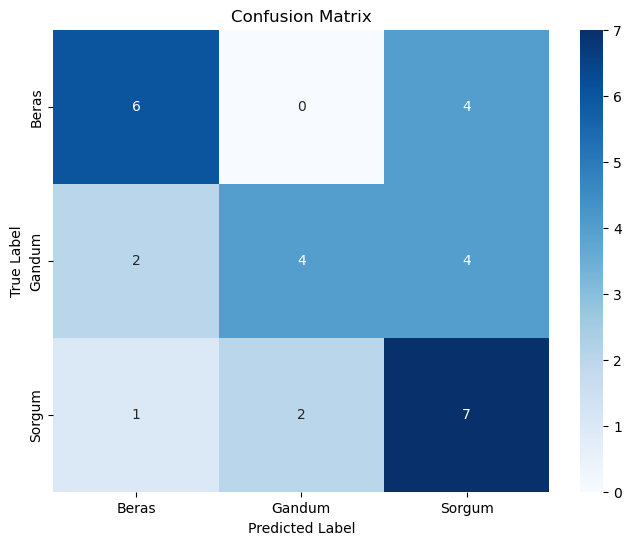


Evaluation Metrics:
Confusion Matrix:
 [[6 0 4]
 [2 4 4]
 [1 2 7]]

Accuracy: 0.5666666666666667

Precision for each class: [0.66666667 0.66666667 0.46666667]
Recall for each class: [0.6 0.4 0.7]
F1 Score for each class: [0.63157895 0.5        0.56      ]

Class-specific accuracies:
Beras: 0.6000
Gandum: 0.4000
Sorgum: 0.7000


In [71]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\rdali\Downloads\Tubes googlenet+strealit done\Test_data_tubes',
    labels='inferred',
    label_mode='categorical',  
    batch_size=32,
    image_size=(180, 180)
)


y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)


conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)


accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat.numpy(), 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=["Beras", "Gandum", "Sorgum"],
            yticklabels=["Beras", "Gandum", "Sorgum"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("\nEvaluation Metrics:")
print("==================")
print("Confusion Matrix:\n", conf_mat.numpy())
print("\nAccuracy:", accuracy.numpy())
print("\nPrecision for each class:", precision.numpy())
print("Recall for each class:", recall.numpy())
print("F1 Score for each class:", f1_score.numpy())


class_accuracies = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
print("\nClass-specific accuracies:")
for i, class_name in enumerate(["Beras", "Gandum", "Sorgum"]):
    print(f"{class_name}: {class_accuracies[i].numpy():.4f}")